# ECE 5470 Lab 6 Report: 3D Image Processing

## by Rufei Ye

In [97]:
import numpy as np
from v4 import vx
from v4 import vd

### Section 2. Three-dimensional filtering



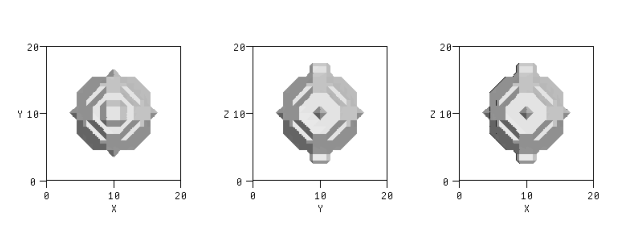

Demonstration of cardinal views
<scaled size: (258 x 772) >


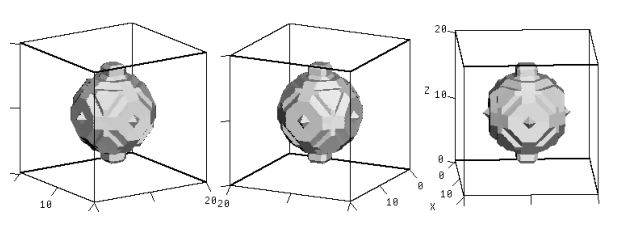

Demonstraion of selected views
<scaled size: (256 x 768) >


In [3]:
## demonstraion of visualization tools
exec(vx.vxsh('t1makepy'))
exec(vx.vxsh('v3view if=t1.vd of=t1vis.vx'))
exec(vx.vxsh('v3view -yo if=t1.vd ang=120 | vtile n=3,1 of=t1vis.vs '))
exec(vx.vxsh('v3view -yo -gif if=t1.vd of=t1vis.gif'))
vd.dispmvx('t1vis.vx', capt='Demonstration of cardinal views')
vd.dispmvx('t1vis.vs', capt='Demonstraion of selected views')

The t1makepy command is a script to generate test images t1.vx and t1.vd. In the t1makepy command, firstly, vgen3d command is used to generate a 3D object scene containing one or more objects. It has different parameters, the first vgen3d command generates an arbitrary ellipsoid with dimension 12x12x12 and translates it by 10 pixels in each axis to set it in the middle. (The dimension range is set by the parameter bb= $bbx, which means the range of all three axis is 0-20.)The second vgen3d command generates a single elliptic cylinder on the same place. Next, vop command does the logical OR operation of two new images and vdim command is used to create frame markers. The output is named t1.vx, a 2D image sequences. Finally, v3pol command converts the image set to 3D polygons using the modified marching cubes algorithm.

v3view command is used to create a visualization of the 3D polygon file in different ways. As the images shows above, the first line shows three orthogonal view-direction renderings of t1.vd. The images in the second line show the animation sequence from Y-axis oblique view, with rotation angle of 120 degrees.


<img src='t1vis.gif' width="140px"> 
    <!-- ![Animation](t1vis.gif) -->
Gif animation of the rotation around Y-axis

Also, an animated gif file is created through the v3view command. 

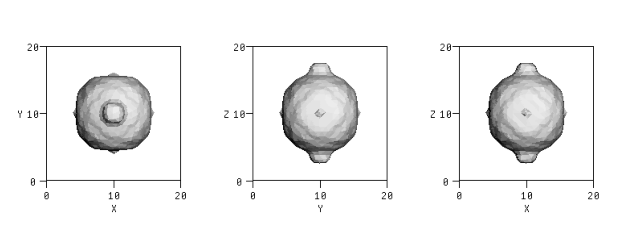

t1.vd with surface smoothing
<scaled size: (258 x 772) >


In [6]:
exec(vx.vxsh('v3pfilt -a t1.vd -o t1f.vd'))
exec(vx.vxsh('v3view  t1f.vd of=t1f.vx'))
vd.dispmvx('t1f.vx', capt='t1.vd with surface smoothing')

Compared with t1.vd, t1f.vd looks smoother. t1f.vd has no angles and no obvious layering. In the first picture, its top, bottom and left and right four corners become small and smooth. The v3pfilt command is a 3D surface smoothing command. In my view, I would not always perform this action on polygons, because smoothing will lose details of the object. Although a smooth image is aesthetically pleasing, the degree of smoothness should be determined by the needs of the image processing.

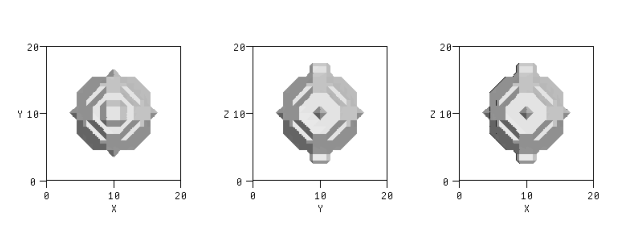

t1vis.vx, input image
<scaled size: (258 x 772) >


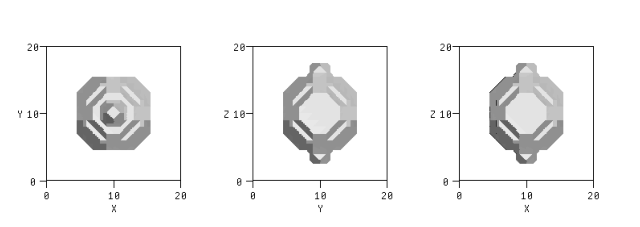

t1.vd with morphological opening
<scaled size: (258 x 772) >


In [18]:
#remove the top and bottom protrusions on the object
exec(vx.vxsh('vmorph t1.vx -ed t=s s=3,3,3 | vdim -c  of=n3.vx'))
exec(vx.vxsh('v3pol -t if=n3.vx of=n3.vd'))
exec(vx.vxsh('v3view n3.vd of=n3.vx'))
vd.dispmvx('t1vis.vx', capt='t1vis.vx, input image')
vd.dispmvx('n3.vx', capt='t1.vd with morphological opening')

In the first try, vmorph does not remove the protrusions. As the images shows above, the top and bottom protrusions still exist, but the small protrusions on the side of the object are removed. In theory, morphological opening should be an appropriate way to remove the protrusions. (Because the morphological closing algorithm fills the image, not removes it.) 

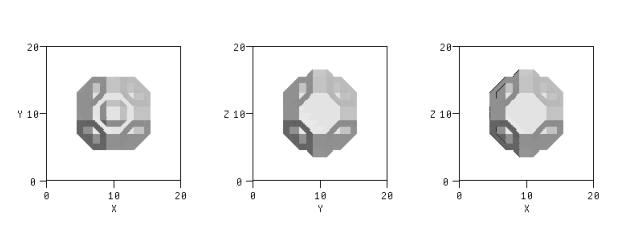

t1.vd with morphological opening, kernel=5*5*5
<scaled size: (258 x 772) >


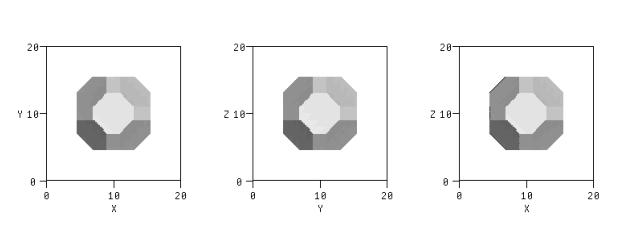

t1.vd with morphological opening, kernel=6*6*6
<scaled size: (258 x 772) >


In [23]:
#remove the top and bottom protrusions on the object
exec(vx.vxsh('vmorph t1.vx -ed t=s s=5,5,5 | vdim -c  of=n3-2.vx'))
exec(vx.vxsh('v3pol -t if=n3-2.vx of=n3-2.vd'))
exec(vx.vxsh(' v3view n3-2.vd of=n3-2.vx'))
vd.dispmvx('n3-2.vx', capt='t1.vd with morphological opening, kernel=5*5*5')
vd.dispmvx('n3-3.vx', capt='t1.vd with morphological opening, kernel=6*6*6')

<img src='t1vis.gif' width="140px">      <img src='n3-2.gif' width="140px">       <img src='n3-3.gif' width="140px"> 

Gif animation of input, kernel=5*5*5, kernel=5*5*5

Still using the spherical kernel, I tried different parameter 's' to set the size of the kernel. As the kernel increases, the top and bottom protrusions are removed. However, the details on the object bevel are also erased. 

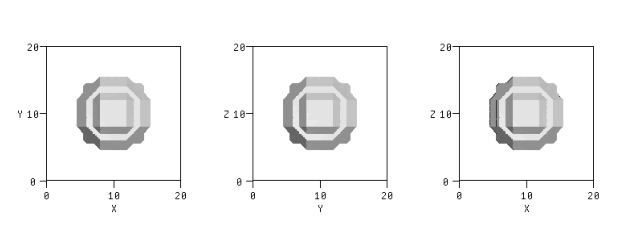

t1.vd with morphological opening, cubic kernel
<scaled size: (258 x 772) >


In [24]:
vd.dispmvx('n3-4.vx', capt='t1.vd with morphological opening, cubic kernel')

When using the cubic kernel(parameter t=c, s=4), the top and bottom protrusions are also removed successfully, but the object's cut surface is also changed to a square. I also tried morphological erosion and morphological dilation. The former removes the bump at kernel=8x8x8, but the whole object is also smaller, while the latter makes the object bigger and bigger. As a result, the morphological opening algorithm with kernel=6*6*6 works the best. It removes the top and bottom protrusions successfully and remains the original size and the basic shape of the object.

### Section 3 Three-dimensional Edge Detector
#### 3.1 3D edge detection algorithm

In [ ]:
#!/usr/bin/env python
""" v3edge: an gradient estimation program for 3D images

"""
from v4 import vx
import sys
import math

def v3edge ( img ) :
 """ compute gradient estimation for vx.Vx struct
 """
 im = img.i
 tmimage = vx.Vx( img ) 
 tmimage.embedim((1,1,1,1,1,1))
 tm = tmimage.i
 
 maxi = 0
 
 #compute the gradient and magnitude
 for z in range(im.shape[0]):
    for y in range(im.shape[1]):
        for x in range(im.shape[2]):
               x_d= round(int(tm[z+1][y+1][x+2])-int(tm[z+1][y+1][x]))
               y_d= round(int(tm[z+1][y+2][x+1])-int(tm[z+1][y][x+1]))
               z_d= round(int(tm[z+2][y+1][x+1])-int(tm[z][y+1][x+1]))
               magnitude = round (math.sqrt(z_d*z_d + y_d*y_d + x_d*x_d))
               #print(magnitude)    
               im[z][y][x] = magnitude 
               maxi = max(magnitude,maxi) #find the max magnitude
               
 #print('maxi:', maxi)
 
 #normalize the pixel value:0~255
 for z in range(im.shape[0]):
    for y in range(im.shape[1]):
        for x in range(im.shape[2]):
               im[z][y][x] = im[z][y][x]*255/maxi
        
        
vargs = vx.vaparse( "if= of= -v  - ")
if '-' in vargs:
   print ("v3edge 3D: an gradient estimation program for 3D images")
   print ("if= input file")
   print ("of= output file")
   print ("[-v] verbose mode")
   sys.exit(0)

for arg in ['if', 'of']:
   if arg not in vargs:
       print ('v3edge error: required parameter %s is missing' % arg)
       sys.exit(1)
optv = '-v' in vargs

ximage = vx.Vx( vargs['if'] )   ;#read image
v3edge(ximage)                 ;#process image
if optv:
   print (ximage.i)             ;# for very small images
ximage.write(vargs['of'])       ;# Write the result file


The v3edge program is designed as an gradient estimation program for 3D images, which is the second stage of edge detection. The main structure of the program remains the same as vdmeanpy. The v3edge program is a 3D gradient strength estimation that computes the gradient and magnitude of 3D images, and it is divided into two parts: computation and normalization. 

Firstly, compute the gradient and magnitude in a 3D image. As in the previous experiments, tmimage is a copy of the original image with a circle of pixels added, so the tm[z+1,y+1,x+1] is the same as im[z,y,x]. In the gradient calculation, I chose to obtain the gradient estimation of the current pixel by subtracting the surrounding pixel values. In specific, in x axis, the gradient estimation of tm[x+1](equals to im[x]) is the subtraction of tm[x+2] and tm[x]. The comparison of the gradient algorithms will be illustrated later in the small image test. Next, magnitude is computed from the gradient estimation of three axis and is assigned to each pixel. At the same time, a variable named maxi is used to record the maximum of gradient estimations.'round' and 'int' are used to aviod a numeric overflow. 

The second part is normalization. After calculation, the magnitude is a number may exceed 255. Because the range of pixel value is 0-255, normalization is necessary in order to output the gradient estimation properly. On every pixel, im[z][y][x] = im[z][y][x]*255/maxi is applied to set the pixel value of output between 0-255.

Next comes the small image test to verify the program.

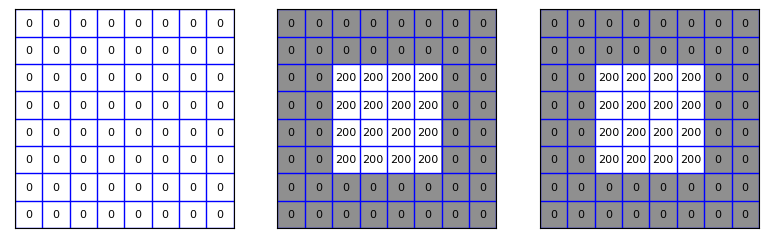

<scaled size: (8 x 8) (8 x 8) (8 x 8) >


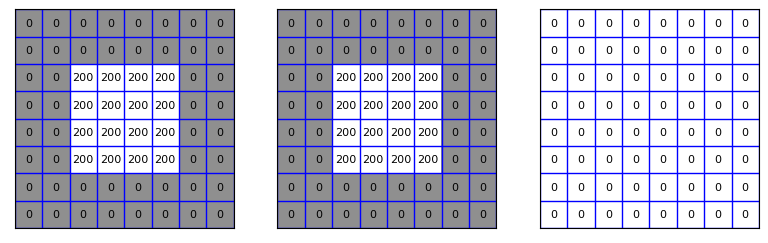

3D test image
<scaled size: (8 x 8) (8 x 8) (8 x 8) >


In [103]:
tim = vx.Vx('tst1')
vd.dispsvx(tim.i[0], tim.i[1], tim.i[2])
vd.dispsvx(tim.i[3], tim.i[4], tim.i[5], capt='3D test image')

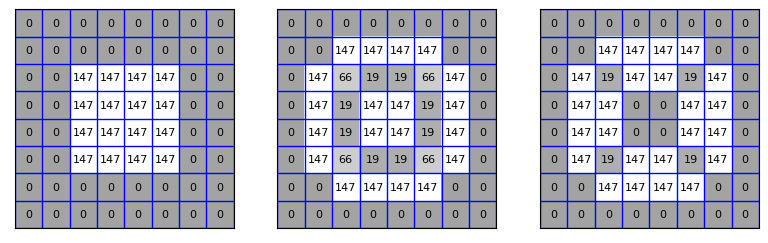

<scaled size: (8 x 8) (8 x 8) (8 x 8) >


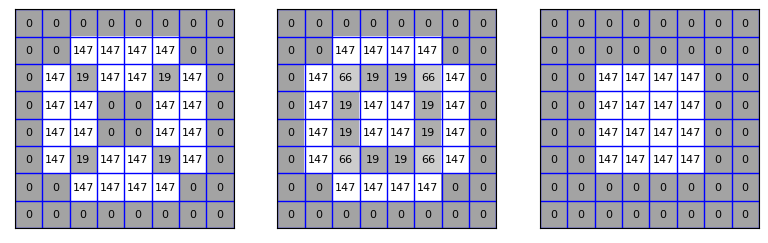

3D test image after v3edge
<scaled size: (8 x 8) (8 x 8) (8 x 8) >


In [32]:
tim = vx.Vx('tst1_1')
vd.dispsvx(tim.i[0], tim.i[1], tim.i[2])
vd.dispsvx(tim.i[3], tim.i[4], tim.i[5], capt='3D test image after v3edge')

tst1 is a 3D test image and it includes a small cube with pixel value of 0 and 200. After applying v3edge, tst1_1 is shown above. Because the gradient calculation of each pixel involves the two pixels before and after it, the output gradient result is inflated compared to the original image. In the first slice of output, the non-zero pixel value already appears. In the next four slices, the boundary of the cube can be seen to be detected and widened with different pixel values. And the last one is the same as the first one. 

Next I used itkwidgets viewer to view the input and output 3D plots, and saved them as png for display.

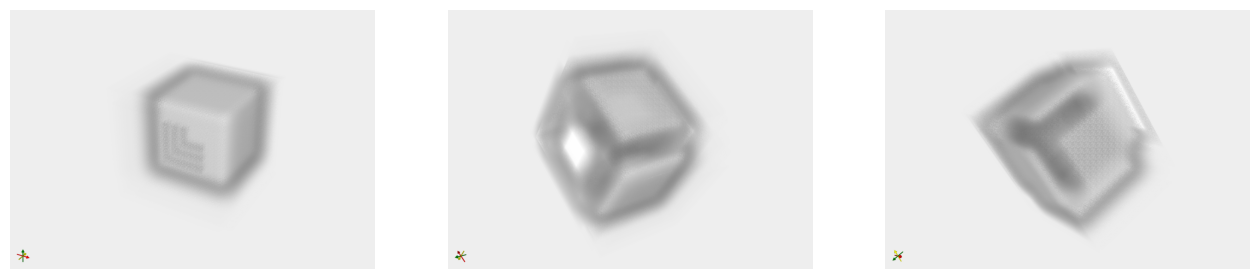

3d display of tst1, tst1_1 and tsttest
<scaled size: (1400 x 1970) (1400 x 1970) (1400 x 1970) >


In [100]:
vd.dispmvx(vx.Vx('tst-3d.png'),vx.Vx('tst1_1-3d.png'),vx.Vx('tsttest-3d.png'),size=2,capt='3d display of tst1, tst1_1 and tsttest')

The first image is 3D display of input test image tst1, and the second image is output tst1_1 after applying the v3edge program. The stereogram visualizes that the algorithm detects the boundaries of the cube almost completely and expands on each face.

The third image is 3D display of the output from another algorithm: compute the gradient estimation from adjacent pixel differences. (which means in one axis, the gradient estimation of tm[x+1](equals to im[x]) is the subtraction of tm[x+1] and tm[x]) The output of this algorithm will be missing a pixel of an edge or a corner on a certain face, resulting in the inability to detect the complete edge. As a result, my v3edge program works well to complete the gradient estimation.

#### 3.2 Experiments and Results

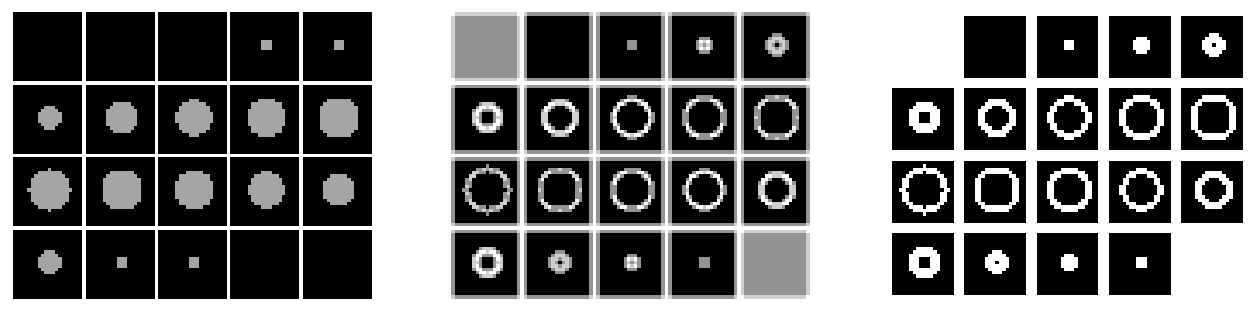

t1g.vx & t1g.vx after v3edge & t1g.vx after v3edge and threshold th=147
<scaled size: (85 x 106) (85 x 106) (85 x 106) >


In [117]:
#v3edge + threshold
exec(vx.vxsh('vtile t1g.vx -ib n=5,4 -xb of=t1gimage'))
exec(vx.vxsh('v3edge t1g.vx of=t1gedge'))
exec(vx.vxsh('vpix if=t1gedge th=147 of=t1gth'))
vd.dispmvx('t1gimage','t1gedge-image','t1gth-image',size=2,capt='t1g.vx & t1g.vx after v3edge & t1g.vx after v3edge and threshold th=147')

The stages of edge detection are low-pass filter, gradient estimation, thresholding, and post processing. As images show above, the first one is the threshold result of ti.vd and it is the input. Because it has no additional noise, low-pass filtering is skipped in this case. The second image shows the result of gradient estimation. In each slice, the boundary of the object is detected well. The third image shows the threshold result using vpix command. The larger the th parameter, the finer the boundary, and when th=148, the edges start to become mutilated and incomplete. After several trials, the best result is obtained when th=147. The third image shows the complete edge in each slice of the object.

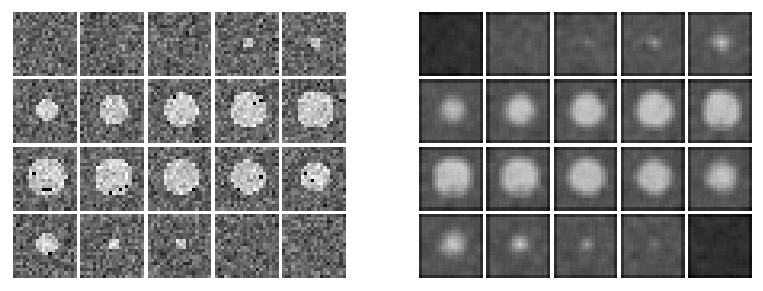

t1n.vx & t1n.vx after mean filter
<scaled size: (85 x 106) (85 x 106) >


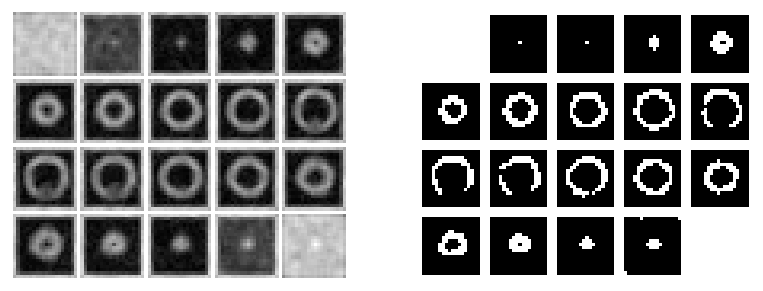

t1n.vx after filter and v3edge & t1n.vx after filter, v3edge and threshold
<scaled size: (85 x 106) (85 x 106) >


In [121]:
#Mean filter + v3edge +threshold
exec(vx.vxsh('vtile t1n.vx -ib n=5,4 -xb of=t1nimage'))
exec(vx.vxsh('v3dmeanpy if=t1n.vx of=t1nfilter'))
exec(vx.vxsh('v3edge t1nfilter of=t1nedge'))
exec(vx.vxsh('vpix if=t1nedge th=120 of=t1nth'))
exec(vx.vxsh('vtile t1nfilter -ib n=5,4 -xb of=t1nfilter-image'))
exec(vx.vxsh('vtile t1nedge -ib n=5,4 -xb of=t1nedge-image'))
exec(vx.vxsh('vtile t1nth -ib n=5,4 -xb of=t1nth-image'))
vd.dispmvx('t1nimage','t1nfilter-image',size=1.2,capt='t1n.vx & t1n.vx after mean filter')
vd.dispmvx('t1nedge-image','t1nth-image',size=1.2,capt='t1n.vx after filter and v3edge & t1n.vx after filter, v3edge and threshold')

 As images show above, the first one is the threshold result of ti.vd and it is the input. The second one is the image after applying the mean filter through v3dmeanpy. The low-pass filter blurs the whole image and at the same time removes the noise on the background. There is some mosaic at the border of the object. In the third image, v3edge is applied on the previous output. The edges of each layer of the image are detected and the mosaic is still present. Finally, the last image is the threshold result with th=120. When th gets smaller, the detected edge becomes wider. On the other hand, when th gets larger, the detected edge becomes thinner, but some details are also missing, for example, the lower edge of several circles in the figure is missing. In this case, th=120 is chosen to show relatively clear and complete edges.

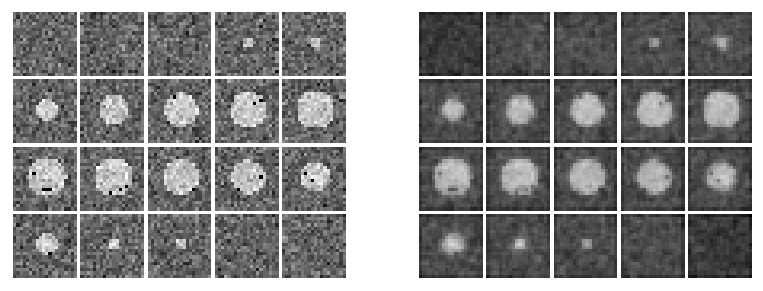

t1n.vx & t1n.vx after Gaussian filter
<scaled size: (85 x 106) (85 x 106) >


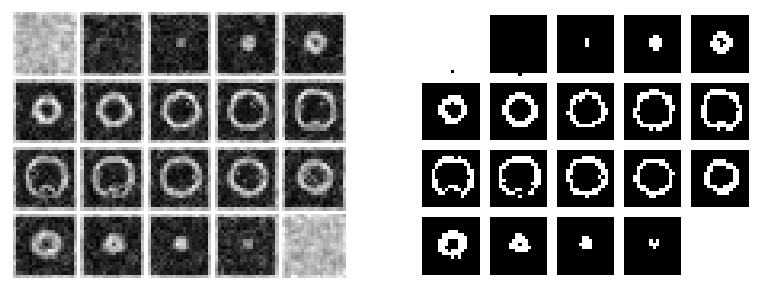

t1n.vx after filter and v3edge & t1n.vx after filter, v3edge and threshold
<scaled size: (85 x 106) (85 x 106) >


In [127]:
#Gaussian filter + v3edge +threshold
exec(vx.vxsh('vtile t1n.vx -ib n=5,4 -xb of=t1nimage'))
exec(vx.vxsh('vgfilt xs=0.6 ys=0.6 zs=0.6 if=t1n.vx of=t1nfilterg'))
exec(vx.vxsh('v3edge t1nfilterg of=t1nedgeg'))
exec(vx.vxsh('vpix if=t1nedgeg th=130 of=t1nthg'))
exec(vx.vxsh('vtile t1nfilterg -ib n=5,4 -xb of=t1nfilterg-image'))
exec(vx.vxsh('vtile t1nedgeg -ib n=5,4 -xb of=t1nedgeg-image'))
exec(vx.vxsh('vtile t1nthg -ib n=5,4 -xb of=t1nthg-image'))
vd.dispmvx('t1nimage','t1nfilterg-image',size=1.2,capt='t1n.vx & t1n.vx after Gaussian filter')
vd.dispmvx('t1nedgeg-image','t1nthg-image',size=1.2,capt='t1n.vx after filter and v3edge & t1n.vx after filter, v3edge and threshold')

As images show above, the first one is the threshold result of ti.vd and it is the input. The second one is the image after applying the Gaussian filter through vgfilt with xs=0.6 ys=0.6 zs=0.6. The Gaussian low-pass filter blurs the whole image and at the same time partly removes the noise on the background. At this point, the Gaussian output does not look as clear as the result of the mean filter. In the third image, v3edge is applied on the previous output. The edges of each layer of the image are detected. Finally, the last image is the threshold result with th=130. When th gets smaller, the detected edge becomes wider. On the other hand, when th gets larger, the detected edge becomes clearer, but some details are also missing, for example, the lower edge of several circles in the figure is missing. After several trials of Gaussian and threshold parameter,  now the best result is shown: the edges are as complete as possible, and the thickness is appropriate. In my view, The output with the current filter selection and parameters is the best possible result.

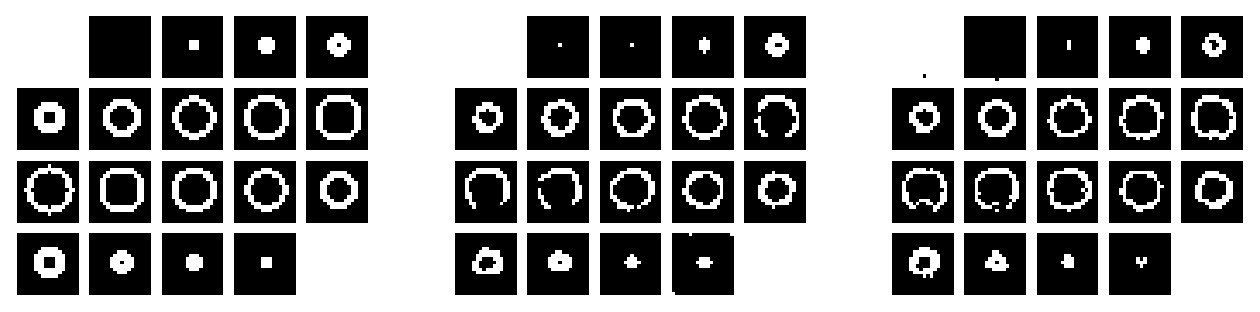

t1g.vx & t1n.vx with mean filter & t1n.vx with Gaussian filter
<scaled size: (85 x 106) (85 x 106) (85 x 106) >


In [129]:
vd.dispmvx('t1gth-image','t1nth-image','t1nthg-image',size=2,capt='t1g.vx & t1n.vx with mean filter & t1n.vx with Gaussian filter')

The above figure shows the results of no noise nor filtering, mean filtering and Gaussian filtering, respectively. Ideally, the perfect look of the last two pictures should be consistent with the first one. Gaussian filtering preserves more detail at the edges.

### 4.Three-dimensional Segmetnation Evaluation



In section4, firstly I marked the boundary of the nodule in slices of the image ctimage.vs, and then the annotation file ctimage.2.bb was generated.

The analsegpy script includes a series of commands to compare the annotation with ground truth. Firstly, vrdiff command compares the manual segmentation ctimage.2.bb with the reference segmentation nodeg.vx, and record some quantitative measures in compare.txt. The “-cp” flag was used to clip the original image to the size of the comparison image. The output file is a byte and color-indexed image named compare.vx. 

Next, vclip, vtile and vccvt commands are used to create a montage visualization of the comparison of the segmentations. With -b and -f parameters, the varend command traces and fills the boundaries of the manual segmentation file ctimage.2.bb. v3pad is used to add a zero padding and vdim command adds a frame marker for it. 

Finally, v3pol is used to convert image set into 3D polygon, and at the same time v3pfilt command smooths the polygonal surface. v3view command is used to create light shaded visualizations of polygon surface representations. After these instructions, the output image is obtained as shown below.

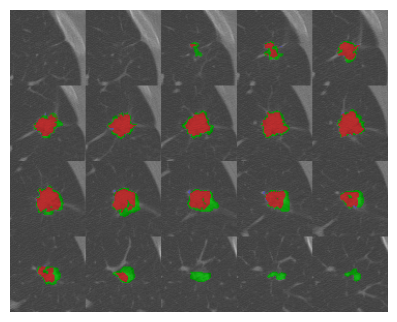

dcompare.vx
<scaled size: (292 x 365) >


In [29]:
vd.dispmvx('dcompare.vx', capt='dcompare.vx')

The dcompare.vx image is an output that shows the result of comparing the manual segmentation with the reference segmentation.  The region shown in red means the pixels are included in both of ctimage.2.bb and nodeg.vx. The region shown in blue means the pixels are included in nodeg.vx but not in ctimage.2.bb, while the region shown in green means the pixels are included in ctimage.2.bb but not in nodeg.vx. From dcompare.vx, the green part is larger than the red part, which means that the segmentation I choose always contains the ground truth. In the third row, there is a little blue region shown on the upper left corner of the pulmonary nodules. The blue region shows some tissues I lost when making the segmentation. Perhaps I should have been more careful in my labeling and considered the connection between the front and back slices more. Tighter borders contribute to more accurate and perfect segmentation.

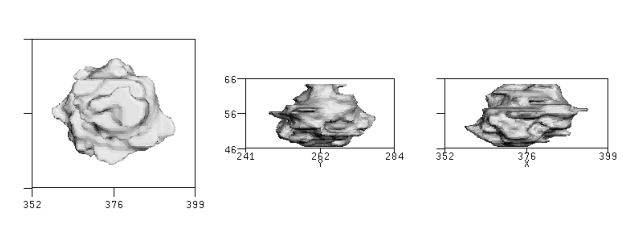

dmregion.vx：my segmentation
<scaled size: (258 x 772) >


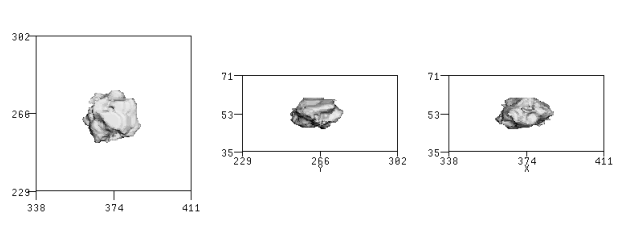

dnodseg.vx: ground truth
<scaled size: (258 x 772) >


In [131]:
vd.dispmvx('dmregion.vx', capt='dmregion.vx：my segmentation')
vd.dispmvx('dnodseg.vx', capt='dnodseg.vx: ground truth')

The first row shows the light shaded visualization of my segmentation, while the second one shows the ground truth. They are the results observed at 3 different angles on different axes. The 3D image visually shows that the shape of my separated result is similar to the ground truth. However, my segmentation is larger, which is consistent with the meaning expressed in the color image results output above. When making annotations, I should have drawn closer to the nodes.

In [ ]:
apcnt	6062
bpcnt	3849
overlap	3805
anotb	2257
bnota	44
union	6106
diff	2301
tp	3805
tn	185738
fp	2257
fn	44
fpc	0.40218
sim	0.62316
sens	0.98857
spec	0.98799
jin	0.62316
dsc	0.76783

compare.txt records some quantitative measures of the comparison. The number of pixels in my segmentation is larger than the ground truth, but the number of overlapping pixels is very close to the number of pixels in groud truth. And 'bnota' means that I lost 44 pixels in the ground truth, which refers to the blue region above. fpc=0.40218 shows that Fraction of Pixels Correct is 40.22%. FPC takes both the overcovered and undercovered regions into consideration. According to the calculation method of FPC, the wide range of separations contains too many irrelevant pixels, resulting in a much lower correct rate. As a result, I should have draw annotations closer and more accurate.

compare.txt also includes some index to help analyze. jin=0.62316 shows the Jaccard index which has a value of 0.623, while dsc=0.76783 shows the Dice coefficient that has a value of 0.768. Dice coefficient and Jaccard index have similar computational logic, using different amount of overlaps divided by the total area, so their results are similar. With these two coefficients, It looks like I got most of it right. 